In [1]:
import sys
from osgeo import gdal
gdal.VersionInfo()

'3060200'

In [9]:
import logging
from pathlib import Path
import wget
import glob
import numpy as np
import rasterio
import pyproj
import xarray as xr
from osgeo import gdal
from osgeo import osr
import netCDF4
import os

In [2]:
print(sys.path)

['/Users/khant/Documents/UFZ/Git/iasdt-workflows/notebooks', '/Users/khant/opt/anaconda3/lib/python39.zip', '/Users/khant/opt/anaconda3/lib/python3.9', '/Users/khant/opt/anaconda3/lib/python3.9/lib-dynload', '', '/Users/khant/.local/lib/python3.9/site-packages', '/Users/khant/opt/anaconda3/lib/python3.9/site-packages', '/Users/khant/opt/anaconda3/lib/python3.9/site-packages/aeosa']


In [3]:
# some_file.py
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
if "../src/data/" in sys.path:
    print("Path not needed")
else:
    sys.path.insert(1, "../src/data/")


In [8]:
def download_data(path_to_download_list, output_dir):
    """Downloads the CHELSA yearly data from the C3S FTP server.

    :param path_to_download_list: The path for the txt file with CHELSA data url list.
    :param: output_dir: The path where data files are downloaded to.

    Returns:
        None
    """
    logger = logging.getLogger(__name__)
    logger.info("downloading CHELSA data...")
    # Download the CHELSA data from the C3S FTP server
    with open(path_to_download_list) as url_list:
        for line in url_list:
            response = wget.download(line, out=output_dir)
            logger.info("downlaoded CHELSA data from {}".format(response))
#down = wget.download("https://os.zhdk.cloud.switch.ch/envicloud/chelsa/chelsa_V2/GLOBAL/annual/swb/CHELSA_swb_2013_V.2.1.tif")
download_data("../references/chelsa/test.txt", "../datasets/raw/chelsa/")

# Trial 1

In [12]:
def process_geotifs(input_dir, output_dir):
    """Iterates over geotiff files, slices data for Europe and converts the data to equal area projection.

    :param input_dir: Path to folder with raw CHELSA data.
    :param: output_dir: Path for storing out files.

    Returns:
        None
    """
    # Define the EPSG codes for the input and output coordinate systems
    output_epsg = 3530  # ETRS89 / LAEA Europe equal area projection

    # Create the output directory if it doesn't already exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over the geotif files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".tif"):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            # Open the input geotif file
            dataset = gdal.Open(input_path)

            # Get the geotransform and projection information
            geotransform = dataset.GetGeoTransform()
            projection = dataset.GetProjection()

            # Convert the geotransform to a spatial reference object
            srs = osr.SpatialReference()
            srs.ImportFromWkt(projection)

            # Create a new spatial reference object for the output coordinate system
            output_srs = osr.SpatialReference()
            output_srs.ImportFromEPSG(output_epsg)

            # Create a transformation object to convert from the input to output coordinate system
            transform = osr.CoordinateTransformation(srs, output_srs)

            # Read the input geotif data
            data = dataset.ReadAsArray()

            # Compute the indices for the Europe region
            x_size = dataset.RasterXSize
            y_size = dataset.RasterYSize
            x_offset = int((-25.0 - geotransform[0]) / (geotransform[1]))
            y_offset = int((72.0 - geotransform[3]) / (geotransform[5]))
            x_count = (
                int(((-10.0 - geotransform[0]) / geotransform[1])) - x_offset
            )
            y_count = (
                int(((35.0 - geotransform[3]) / geotransform[5])) - y_offset
            )

            # Slice the data for the Europe region
            data = data[y_offset : y_offset + y_count, x_offset : x_offset + x_count]

            # Convert the data to the output coordinate system
            x_res = (geotransform[1] * x_count) / 1000.0
            y_res = (geotransform[5] * y_count) / 1000.0
            output_geotransform = (
                geotransform[0] + x_offset * geotransform[1],
                x_res,
                0.0,
                geotransform[3] + y_offset * geotransform[5],
                0.0,
                -y_res,
            )
            output_data = np.empty((y_count, x_count), dtype=np.float32)
            output_data[:] = np.nan
            output_dataset = gdal.GetDriverByName("GTiff").Create(
                output_path, x_count, y_count, 1, gdal.GDT_Float32
            )
            output_dataset.SetGeoTransform(output_geotransform)
            output_dataset.SetProjection(output_srs.ExportToWkt())
            gdal.ReprojectImage(
                dataset, output_dataset, projection, output_srs.ExportToWkt(), gdal
            )

process_geotifs("../datasets/raw/chelsa/", "../datasets/processed/chelsa/")

TypeError: in method 'ReprojectImage', argument 5 of type 'GDALResampleAlg'

# Trial 2

In [3]:
import glob
import numpy as np
import rasterio
import pyproj
import xarray as xr

def process_geotiffs_2(input_dir, output_file):
    # Define projection for Europe (Equal Area projection)
    europe_crs = pyproj.crs.CRS.from_string('+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +units=m +no_defs')
    
    # Define output grid shape
    xres, yres = 10000, 10000 # 10 km resolution
    xsize, ysize = 447, 547 # Grid shape for Europe
    
    # Create empty xarray dataset to store output
    data = np.zeros((1, ysize, xsize), dtype=np.float32)
    coords = {'latitude': np.linspace(85, 35, ysize), 'longitude': np.linspace(-25, 50, xsize)}
    ds = xr.Dataset({'data': (['time', 'latitude', 'longitude'], data)}, coords=coords)
    
    # Iterate over GeoTIFF files
    for tif_file in glob.glob(input_dir + '*.tif'):
        with rasterio.open(tif_file) as src:
            # Crop to Europe
            window = rasterio.windows.from_bounds(*src.bounds, europe_crs)
            data = src.read(1, window=window)
            transform = src.window_transform(window)
            
            # Reproject to Equal Area projection
            europe_transform = rasterio.warp.transform_bounds(src.crs, europe_crs, *src.bounds)
            europe_data, _ = rasterio.warp.reproject(data, transform, src.crs, europe_crs, shape=(ysize, xsize), 
                                                      bounds=europe_transform, resampling=rasterio.warp.Resampling.bilinear)
            
            # Downscale to 10 km grid
            europe_data = rasterio.warp.downscale_local_mean(europe_data, (int(yres/src.res[0]), int(xres/src.res[1])))
            
            # Add data to xarray dataset
            ds['data'][0, :, :] += europe_data.astype(np.float32)
    
    # Convert output to netCDF4 format
    ds.to_netcdf(output_file)

process_geotiffs_2("../datasets/raw/chelsa/", "../datasets/processed/chelsa/")

WindowError: A transform object is required to calculate the window

# Trial 3

In [2]:
!pip install rioxarray

  Using cached rioxarray-0.14.1-py3-none-any.whl (53 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 11.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 10.2 MB/s eta 0:00:0000:0100:01
  Using cached affine-2.4.0-py3-none-any.whl (15 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)


In [1]:
import os
import xarray as xr
import numpy as np
import rioxarray as rxr
import rasterio
from rasterio.enums import Resampling


def geotiff_to_netcdf_3(directory_path, output_file_path):
    
    # Define the bounding box for Europe
    europe_bounds = [-25, 35, 45, 75]

    # Iterate over all files in the directory
    for filename in os.listdir(directory_path):
        print("---------------------------------------------")
        output=filename.rsplit("_V")
        # Check if the file is a GeoTIFF
        if filename.endswith(".tif"):
            print(f"Reading {filename}...")

            # Open the GeoTIFF using rioxarray
            data = rxr.open_rasterio(os.path.join(directory_path, filename))
            print(f"Processing {filename} as xarray...")
           
            # Slice the data for Europe
            data_europe = data.rio.clip_box(*europe_bounds)
            print(f"Clipping {filename} for Europe...")

            # Reproject the data to ESPG-3530
            data_europe = data_europe.rio.reproject("EPSG:3035")
            print(f"Reprojecting {filename} as ESPG:3035...")
            
            # Resample data to 10x10 KM grids based on https://corteva.github.io/rioxarray/stable/examples/resampling.html
            downscale_factor = 10
            new_width = data_europe.rio.width * downscale_factor
            new_height = data_europe.rio.height * downscale_factor
            data_resampled= data_europe.rio.reproject(
                data_europe.rio.crs,
                shape=(new_height, new_width),
                resampling=Resampling.average,)
            print(f"Resamplimg {filename} using average algorithm...")

            # Convert to xarray DataArray to xrray Dataset
            dsout=data_resampled.to_dataset(name=f"{output[0]}")

            print(f"Final dataset for {output[0]}: ")
            print(dsout)

            # Convert the data to a netCDF4 file using xarray
            dsout.to_netcdf(
                output_file_path, 
                mode="a",
                group="/",
                format="NETCDF4"
            )
            print(f"{filename} processed and saved to {output_file_path} as {output[0]}")
            
geotiff_to_netcdf_3("../datasets/raw/chelsa/", "../datasets/processed/chelsa/2-resmpled_CHELSA_bio1-19.nc")

---------------------------------------------
Reading CHELSA_bio15_1981-2010_V.2.1.tif...
Processing CHELSA_bio15_1981-2010_V.2.1.tif as xarray...
Clipping CHELSA_bio15_1981-2010_V.2.1.tif for Europe...
Reprojecting CHELSA_bio15_1981-2010_V.2.1.tif as ESPG:3035...
Resamplimg CHELSA_bio15_1981-2010_V.2.1.tif using cubic algorithm...
Final dataset for CHELSA_bio15_1981-2010: 
<xarray.Dataset>
Dimensions:                 (x: 105610, y: 79730, band: 1)
Coordinates:
  * x                       (x) float64 1.215e+06 1.215e+06 ... 7.428e+06
  * y                       (y) float64 6.018e+06 6.018e+06 ... 1.328e+06
  * band                    (band) int64 1
    spatial_ref             int64 0
Data variables:
    CHELSA_bio15_1981-2010  (band, y, x) uint16 65535 65535 ... 65535 65535
CHELSA_bio15_1981-2010_V.2.1.tif processed and saved to ../datasets/processed/chelsa/2-resmpled_CHELSA_bio1-19.nc as CHELSA_bio15_1981-2010
---------------------------------------------
Reading CHELSA_bio14_1981-201

: 

: 

In [12]:
import xarray as xr
ds_disk = xr.open_dataset("../datasets/processed/chelsa/test.nc", engine='netcdf4')
ds_disk

KeyError: None

In [22]:
from netCDF4 import Dataset #pylint: disable=no-name-in-module
import numpy as np


f = Dataset("../datasets/processed/chelsa/CHELSA_bio1_1981-2010_.nc", "w", format="NETCDF4")
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 


In [1]:
import os
import xarray as xr
import numpy as np
import rioxarray as rxr
import rasterio


def geotiff_to_netcdf_4(directory_path, output_file_path):
    
    # Define the bounding box for Europe
    europe_bounds = [-25, 35, 45, 75]

    # Iterate over all files in the directory
    for filename in os.listdir(directory_path):
        print("---------------------------------------------")
        output=filename.rsplit("_V")
        # Check if the file is a GeoTIFF
        if filename.endswith(".tif"):
            print(f"Reading {filename}...")

            # Open the GeoTIFF using rioxarray
            data = rxr.open_rasterio(os.path.join(directory_path, filename))
            print(f"Processing {filename} as xarray...")
            dsout=data.to_dataset(name=f"{output[0]}")

            print(f"Final dataset for {output[0]}: ")
            print(dsout)

            # Convert the data to a netCDF4 file using xarray
            dsout.to_netcdf(
                output_file_path, 
                mode="a",
                group=f"{output[0]}",
                format="NETCDF4"
            )
            print(f"{filename} processed and saved to {output_file_path} as {output[0]}")
            
geotiff_to_netcdf_4("../datasets/raw/temp/", "../datasets/processed/chelsa/CHELSA_bio1-4.nc")    

---------------------------------------------
Reading CHELSA_bio2_1981-2010_V.2.1.tif...
Processing CHELSA_bio2_1981-2010_V.2.1.tif as xarray...
Final dataset for CHELSA_bio2_1981-2010: 
<xarray.Dataset>
Dimensions:                (band: 1, x: 43200, y: 20880)
Coordinates:
  * band                   (band) int64 1
  * x                      (x) float64 -180.0 -180.0 -180.0 ... 180.0 180.0
  * y                      (y) float64 84.0 83.99 83.98 ... -89.98 -89.99 -90.0
    spatial_ref            int64 0
Data variables:
    CHELSA_bio2_1981-2010  (band, y, x) uint16 ...
CHELSA_bio2_1981-2010_V.2.1.tif processed and saved to ../datasets/processed/chelsa/CHELSA_bio1-4.nc as CHELSA_bio2_1981-2010
---------------------------------------------
Reading CHELSA_bio3_1981-2010_V.2.1.tif...
Processing CHELSA_bio3_1981-2010_V.2.1.tif as xarray...
Final dataset for CHELSA_bio3_1981-2010: 
<xarray.Dataset>
Dimensions:                (band: 1, x: 43200, y: 20880)
Coordinates:
  * band                  

In [58]:
import s3fs
import os
def intaker(path_to_download_list, output_dir):
    """Downloads the CHELSA yearly data from the C3S S3 server.

    :param path_to_download_list: The path for the txt file with CHELSA data url list.
    :param: output_dir: The path where data files are downloaded to.

    Returns:
        None
    """
    s3 = s3fs.S3FileSystem(anon=True, endpoint_url="https://os.zhdk.cloud.switch.ch/")
    with open(path_to_download_list) as url_list:
        for line in url_list:
            print(line.strip())
            head, tail = os.path.split(line)
            tail = tail.strip()
            s3.get(line.strip(), output_dir)

intaker("/Users/khant/Documents/UFZ/Git/iasdt-workflows/references/chelsa/test.txt", "/Users/khant/Documents/UFZ/Git/iasdt-workflows/datasets/raw/chelsa/"),



envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio10_1981-2010_V.2.1.tif
envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio11_1981-2010_V.2.1.tif


KeyboardInterrupt: 

In [ ]:
import wget
import os

def download_data(path_to_download_list, output_dir):
    """Downloads the CHELSA yearly data from the C3S FTP server.

    :param path_to_download_list: The path for the txt file with CHELSA data url list.
    :param: output_dir: The path where data files are downloaded to.

    Returns:
        None
    """
    # Download the CHELSA data from the C3S FTP server
    with open(path_to_download_list) as url_list:
        for line in url_list:
            response = wget.download(line, out=output_dir)
            print("downlaoded CHELSA data from {}".format(response))

download_data("/Users/khant/Documents/UFZ/Git/iasdt-workflows/references/chelsa/test.txt", "/Users/khant/Documents/UFZ/Git/iasdt-workflows/datasets/raw/chelsa/")

In [22]:
# -*- coding: utf-8 -*-
import sys, glob, os, json, hashlib, time
from pathlib import Path
import wget
import numpy as np
import pyproj
import netCDF4
import xarray as xr
import rioxarray as rxr
import rasterio
from rasterio.enums import Resampling
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
import s3fs
import deepdiff



def vSensor(path_file, logs_feedback, logs_diff):
    """Senses new CHELSA data from their S3 server.

    :param input_path: The path for S3 CHELSA data directory where to check new data.

    Returns:

    """

    #Read each line of input path
    with open(path_file) as file:
        lines = [line.rstrip() for line in file]

    #TODO: Change URL string to environment variable
    s3 = s3fs.S3FileSystem(anon=True, endpoint_url="https://os.zhdk.cloud.switch.ch/")
    for i in lines:
        #file_list = s3.ls(path=f"{i}")
        new_log = []
        print(f"{i}")
        metadata = s3.metadata(path=f"{i}", refresh=False)
        info = s3.info(path=f"{i}")
        metadata.update(info)
        metadata["LastModified"] = metadata["LastModified"].strftime(
                "%Y-%m-%d %H:%M:%S"
            )
            # append new metadata to the metadata file
        new_log.append(metadata)
    with open(f"{logs_feedback}{round(time.time())}.json", "w+") as f:
        json.dump(new_log, f)

    # Compare the new metadata with the previous metadata using DIFF
    list_of_log_files = glob.glob(
        f"{logs_feedback}*.json"
    )
    list_of_log_files.sort(key=os.path.getmtime)
    # Get the second oldest file
    if len(list_of_log_files) > 1:
        compare_file = list_of_log_files[1]
    else:
        compare_file = list_of_log_files[0]

    with open(f"{compare_file}", "r") as f:
        # TODO: Validate the difference between the previous and new metadata
        data = json.load(f)
        print(data)
        diff = deepdiff.DeepDiff(data, new_log, view="tree")
        diff_json = json.dumps(diff.to_json(), indent=2)
        with open(f"{logs_diff}{round(time.time())}.json", "w+") as d:
            json.dump(json.loads(diff_json), d)
    return True

vSensor(
                "../references/chelsa/test.txt",
                "../logs/feedback/chelsa/",
                "../logs/diff/chelsa/",
            ),


envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio10_1981-2010_V.2.1.tif
envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio11_1981-2010_V.2.1.tif
envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio12_1981-2010_V.2.1.tif
envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio13_1981-2010_V.2.1.tif
envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio14_1981-2010_V.2.1.tif
[{'mtime': '1607524410', 'ETag': '"a4fc9593bdc3b8cce0c27598f55f9cba"', 'LastModified': '2021-03-01 11:26:59', 'size': 178915498, 'name': 'envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio14_1981-2010_V.2.1.tif', 'type': 'file', 'StorageClass': 'STANDARD', 'VersionId': None, 'ContentType': 'image/tiff'}]


(True,)

In [5]:
import s3fs
list =["envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio10_1981-2010_V.2.1.tif",
"envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio11_1981-2010_V.2.1.tif",
"envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio12_1981-2010_V.2.1.tif",
"envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio13_1981-2010_V.2.1.tif",
"envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio14_1981-2010_V.2.1.tif"]

with open("/Users/khant/Documents/UFZ/Git/iasdt-workflows/references/chelsa/test.txt") as file:
    lines = [line.rstrip() for line in file]
    print(lines)

s3 = s3fs.S3FileSystem(anon=True, endpoint_url="https://os.zhdk.cloud.switch.ch/")
for x in list:
    metadata = s3.info(path=x, refresh=False)
    print(metadata)

['https://os.zhdk.cloud.switch.ch/envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio10_1981-2010_V.2.1.tif', 'https://os.zhdk.cloud.switch.ch/envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio11_1981-2010_V.2.1.tif', 'https://os.zhdk.cloud.switch.ch/envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio12_1981-2010_V.2.1.tif', 'https://os.zhdk.cloud.switch.ch/envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio13_1981-2010_V.2.1.tif', 'https://os.zhdk.cloud.switch.ch/envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio14_1981-2010_V.2.1.tif']
{'ETag': '"8f55e45fe6b0e8e9339e8c63cd551fdb"', 'LastModified': datetime.datetime(2021, 8, 28, 1, 7, 41, tzinfo=tzutc()), 'size': 123145240, 'name': 'envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_bio10_1981-2010_V.2.1.tif', 'type': 'file', 'StorageClass': 'STANDARD', 'VersionId': None, 'ContentType': 'image/tiff'}
{'ETag': '"

In [72]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/Users/khant/Documents/UFZ/Git/iasdt-workflows/references/chelsa/base.csv', delimiter=",", encoding='unicode_escape')

# Get unique values in the "ClimModel" column
clim_model_list = df['ClimModel'].unique().tolist()

# Get unique values in the "ClimScenario" column
clim_scenario_list = df['ClimScenario'].unique().tolist()

# Get unique values in the "TimePeriod" column
time_period_list = df['TimePeriod'].unique().tolist()

# Print the lists
print("Unique values in the 'ClimModel' column:", clim_model_list)
print("Unique values in the 'ClimScenario' column:", clim_scenario_list)
print("Unique values in the 'TimePeriod' column:", time_period_list)


Unique values in the 'ClimModel' column: ['Current', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'UKESM1-0-LL']
Unique values in the 'ClimScenario' column: ['Current', 'ssp126', 'ssp370', 'ssp585']
Unique values in the 'TimePeriod' column: ['1981-2010', '2011-2040', '2041-2070', '2071-2100']


In [79]:
len(df["Var"].unique())

46

In [30]:
import os
import glob

# Specify the directory you want to search
directory = '/Users/khant/Documents/UFZ/BioDT/NC/'

# Get list of all files in the directory
files = glob.glob(os.path.join(directory, '*.nc'))

# Initialize lists to hold parts of filenames
parts = []
part1 = []
part2 = []
part3 = []
part4 = []
part5 = []


# Loop over files
for file in files:
    # Get the base name of the file and split it by "_"
    base_name = os.path.basename(file)
    name_parts = base_name.split("_")
    parts.append(name_parts)
    

    # Add parts to respective lists
    if len(name_parts) >= 2:
        part1.append(name_parts[0])
        part2.append(name_parts[1])
        part3.append(name_parts[2])
        part4.append(name_parts[3])
    else:
        print(f"File {base_name} does not have enough parts.")


# Now part1, part2, and part3 lists hold the respective parts of the filenames

In [17]:
part4
uniques2 = set(part4)
scenarios2 = list(uniques2)
scenarios2


['ukesm1-0-ll',
 'V.2.1.nc',
 'gfdl-esm4',
 'mpi-esm1-2-hr',
 'mri-esm2-0',
 'ipsl-cm6a-lr']

In [39]:
import xarray as xr
import glob

# Get a list of all netCDF files
files = glob.glob('/Users/khant/Documents/UFZ/BioDT/NC/*_gfdl-esm4_ssp585_*.nc')

# Open all files as a single xarray.Dataset
ds = xr.open_mfdataset(files)

ds

<xarray.Dataset>
Dimensions:                                 (easting: 390, northing: 404)
Coordinates:
  * easting                                 (easting) float64 2.635e+06 ... 6...
  * northing                                (northing) float64 5.415e+06 ... ...
Data variables: (12/139)
    bio10__2011_2040__GFDL_ESM4__ssp585     (northing, easting) float32 dask.array<chunksize=(404, 390), meta=np.ndarray>
    crs                                     int32 -2147483647
    bio10__2041_2070__GFDL_ESM4__ssp585     (northing, easting) float32 dask.array<chunksize=(404, 390), meta=np.ndarray>
    bio10__2071_2100__GFDL_ESM4__ssp585     (northing, easting) float32 dask.array<chunksize=(404, 390), meta=np.ndarray>
    bio11__2011_2040__GFDL_ESM4__ssp585     (northing, easting) float32 dask.array<chunksize=(404, 390), meta=np.ndarray>
    bio11__2041_2070__GFDL_ESM4__ssp585     (northing, easting) float32 dask.array<chunksize=(404, 390), meta=np.ndarray>
    ...                                      ...
    scd__2011_2040__GFDL_ESM4__ssp585       (northing, easting) float32 dask.array<chunksize=(404, 390), meta=np.ndarray>
    scd__2041_2070__GFDL_ESM4__ssp585       (northing, easting) float32 dask.array<chunksize=(404, 390), meta=np.ndarray>
    scd__2071_2100__GFDL_ESM4__ssp585       (northing, easting) float32 dask.array<chunksize=(404, 390), meta=np.ndarray>
    swe__2011_2040__GFDL_ESM4__ssp585       (northing, easting) float32 dask.array<chunksize=(404, 390), meta=np.ndarray>
    swe__2041_2070__GFDL_ESM4__ssp585       (northing, easting) float32 dask.array<chunksize=(404, 390), meta=np.ndarray>
    swe__2071_2100__GFDL_ESM4__ssp585       (northing, easting) float32 dask.array<chunksize=(404, 390), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.4
    created_by:    R packages ncdf4 and terra (version 1.7-71)
    date:          2024-03-05 11:33:05
    Var:           bio10
    TimePeriod:    2011_2040
    ClimModel:     GFDL_ESM4
    ClimScenario:  ssp585
    Long_name:     mean daily mean air temperatures of the warmest quarter
    unit:          deg C
    explanation:   The warmest quarter of the year is determined (to the near...

In [74]:
import xarray as xr
import glob

# Create an empty dictionary to store the datasets
datasets_m = {}
datasets_c = {}


for i in clim_model_list:
    for j in clim_scenario_list:
        for t in time_period_list:
            # Get a list of all netCDF files
            files = glob.glob(f'/Users/khant/Documents/UFZ/BioDT/NC/*_{i}_{j}_{t}_*.nc')

            # Open all files as a single xarray.Dataset
            ds = xr.open_mfdataset(files)
            key = f"{i}_{j}_{t}"
            ds.attrs['ClimateModel'] = i
            ds.attrs['ClimateScenario'] = j
            ds.attrs['TimePeriod'] = t
            datasets_m[key] = ds
            #datasets_c[key] = ds

OSError: no files to open

# Works with `NC` folder

In [133]:
import xarray as xr

sample = xr.open_dataset('/Users/khant/Documents/UFZ/BioDT/NC/CHELSA_bio1_2011-2040_gfdl-esm4_ssp126_V.2.1.nc')
sample


<xarray.Dataset>
Dimensions:                             (easting: 390, northing: 404)
Coordinates:
  * easting                             (easting) float64 2.635e+06 ... 6.525...
  * northing                            (northing) float64 5.415e+06 ... 1.38...
Data variables:
    bio1__2011_2040__GFDL_ESM4__ssp126  (northing, easting) float32 ...
    crs                                 int32 ...
Attributes:
    Conventions:   CF-1.4
    created_by:    R packages ncdf4 and terra (version 1.7-71)
    date:          2024-03-05 11:33:20
    Var:           bio1
    TimePeriod:    2011_2040
    ClimModel:     GFDL_ESM4
    ClimScenario:  ssp126
    Long_name:     mean annual air temperature
    unit:          deg C
    explanation:   mean annual daily mean air temperatures averaged over 1 year

In [82]:
import xarray as xr
import os
import numpy as np
from natsort import natsorted

# Define the directory path where the netCDF files are located
directory = "/Users/khant/Documents/UFZ/BioDT/NC/"

# Get a list of all netCDF files in the directory
files = natsorted([file for file in os.listdir(directory) if file.endswith(".nc")])

# Create an empty dictionary to store the datasets
datasets_m = {}
datasets_c = {}
crs =  "PROJCS['ETRS89-extended / LAEA Europe',GEOGCS['ETRS89',DATUM['European_Terrestrial_Reference_System_1989',SPHEROID['GRS 1980',6378137,298.257222101]],PRIMEM['Greenwich',0],UNIT['degree',0.0174532925199433,AUTHORITY['EPSG','9122']],AUTHORITY['EPSG','4258']],PROJECTION['Lambert_Azimuthal_Equal_Area'],PARAMETER['latitude_of_center',52],PARAMETER['longitude_of_center',10],PARAMETER['false_easting',4321000],PARAMETER['false_northing',3210000],UNIT['metre',1],AXIS['Northing',NORTH],AXIS['Easting',EAST],AUTHORITY['EPSG','3035']]"
# Iterate over each netCDF file
for file in files:
    # Open the netCDF file using xarray
    ds = xr.open_dataset(os.path.join(directory, file))
    
    if "ClimModel" in ds.attrs and "ClimScenario" in ds.attrs and "TimePeriod" in ds.attrs:
        # Get the unique ClimModel and ClimScenario attributes
        clim_model = ds.attrs["ClimModel"]
        clim_scenario = ds.attrs["ClimScenario"]
        time_period = str(ds.attrs["TimePeriod"])
        variables = list(ds.data_vars)
        ds[variables[0]].attrs["LongName"] = ds.attrs["Long_name"]
        #ds[variables[0]].attrs["Var"] = ds.attrs["Var"]
        ds[variables[0]].attrs["Explanation"] = ds.attrs["explanation"]
        #crs_wkt = ds[variables[1]].attrs["crs_wkt"].replace(ds[variables[1]].attrs["crs_wkt"], crs)
        #print(crs_wkt)
        #ds.attrs['Conventions'] = "CF-1.5"
        #ds.attrs['spatial_ref'] = crs_wkt
        #ds[variables[1]].attrs["grid_mapping_name"] = "crs"
        #ds[variables[1]].attrs["crs_wkt"] = crs
        #ds[variables[1]].attrs["spatial_ref"] = crs
        #ds[variables[0]].attrs["grid_mapping"] = "crs"
        #ds.attrs['proj4'] = ds[variables[1]].attrs["proj4"]
        #ds.attrs['epsg_code'] = ds[variables[1]].attrs["epsg_code"]
        #ds.attrs['geotransform'] = ds[variables[1]].attrs["geotransform"]
        #ds.attrs['crs'] = ds[variables[1]].attrs["crs_wkt"]
        ds[variables[0]].attrs["grid_mapping"] = "spatial_ref"
        ds = ds.rio.write_crs("EPSG:3035", inplace=True).rio.set_spatial_dims(x_dim="easting",y_dim="northing",inplace=True).rio.write_coordinate_system(inplace=True)
        ds = ds.rename({variables[0]: ds.attrs["Var"]})
        ds = ds.drop_vars(variables[1])
        
        
        # Create a key for the dataset dictionary using the ClimModel and ClimScenario attributes
        key = f"{clim_model}_{clim_scenario}_{time_period}"

        # Store the dataset in the dictionary
        if key not in datasets_m:
            datasets_m[key]=[]
        datasets_m[key].append(ds)
    # Get the unique ClimModel and ClimScenario attributes
    else:
        datasets_c["Current"] = ds


In [83]:
mergy = xr.merge(datasets_m["Current_Current_Current"])
mergy

<xarray.Dataset>
Dimensions:      (easting: 390, northing: 404)
Coordinates:
  * easting      (easting) float64 2.635e+06 2.645e+06 ... 6.515e+06 6.525e+06
  * northing     (northing) float64 5.415e+06 5.405e+06 ... 1.395e+06 1.385e+06
    spatial_ref  int64 0
Data variables: (12/46)
    bio1         (northing, easting) float32 ...
    bio2         (northing, easting) float32 ...
    bio3         (northing, easting) float32 ...
    bio4         (northing, easting) float32 ...
    bio5         (northing, easting) float32 ...
    bio6         (northing, easting) float32 ...
    ...           ...
    ngd0         (northing, easting) float32 ...
    ngd5         (northing, easting) float32 ...
    ngd10        (northing, easting) float32 ...
    npp          (northing, easting) float32 ...
    scd          (northing, easting) float32 ...
    swe          (northing, easting) float32 ...
Attributes:
    Conventions:   CF-1.4
    created_by:    R packages ncdf4 and terra (version 1.7-71)
    date:          2024-03-05 11:32:33
    Var:           bio1
    TimePeriod:    Current
    ClimModel:     Current
    ClimScenario:  Current
    Long_name:     mean annual air temperature
    unit:          deg C
    explanation:   mean annual daily mean air temperatures averaged over 1 year

In [84]:
#encode = {'gzip': True, 'complevel': 9}
for key, ds in datasets_m.items():
# Combine all datasets into a single dataset
    merged_ds = xr.merge(ds)
    del merged_ds.attrs["Var"]
    del merged_ds.attrs["Long_name"]
    del merged_ds.attrs["unit"]
    del merged_ds.attrs["explanation"]
    merged_ds.attrs["Authors"] = "Taimur Khan & Dr. Ahmed El-Gabbas, Helmholz Centre for Environmental Research (UFZ)"
    merged_ds.to_netcdf(f'/Users/khant/Documents/UFZ/BioDT/NC_converted/{key}.nc')
    

In [86]:
da = xr.open_dataset("http://localhost/Current_Current_Current.nc", engine="pydap", decode_times=False, chunks=None)
da

<xarray.Dataset>
Dimensions:      (northing: 404, easting: 390)
Coordinates:
    spatial_ref  int32 ...
  * easting      (easting) float64 2.635e+06 2.645e+06 ... 6.515e+06 6.525e+06
  * northing     (northing) float64 5.415e+06 5.405e+06 ... 1.395e+06 1.385e+06
Data variables: (12/46)
    bio1         (northing, easting) float32 ...
    bio2         (northing, easting) float32 ...
    bio3         (northing, easting) float32 ...
    bio4         (northing, easting) float32 ...
    bio5         (northing, easting) float32 ...
    bio6         (northing, easting) float32 ...
    ...           ...
    ngd0         (northing, easting) float32 ...
    ngd5         (northing, easting) float32 ...
    ngd10        (northing, easting) float32 ...
    npp          (northing, easting) float32 ...
    scd          (northing, easting) float32 ...
    swe          (northing, easting) float32 ...
Attributes:
    Conventions:   CF-1.4
    created_by:    R packages ncdf4 and terra (version 1.7-71)
    date:          2024-03-05 11:32:33
    TimePeriod:    Current
    ClimModel:     Current
    ClimScenario:  Current
    Authors:       Taimur Khan & Dr. Ahmed El-Gabbas, Helmholz Centre for Env...

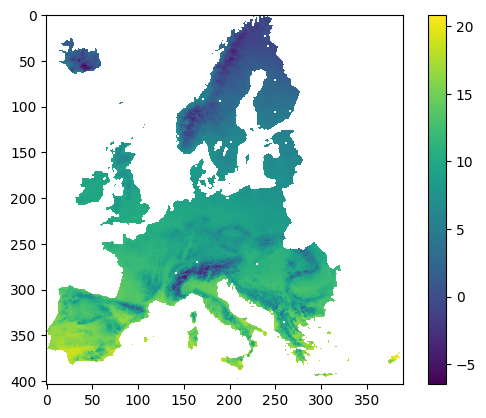

KeysView(<xarray.Dataset>
Dimensions:      (northing: 404, easting: 390)
Coordinates:
    spatial_ref  int32 ...
  * easting      (easting) float64 2.635e+06 2.645e+06 ... 6.515e+06 6.525e+06
  * northing     (northing) float64 5.415e+06 5.405e+06 ... 1.395e+06 1.385e+06
Data variables: (12/46)
    bio1         (northing, easting) float32 ...
    bio2         (northing, easting) float32 ...
    bio3         (northing, easting) float32 ...
    bio4         (northing, easting) float32 ...
    bio5         (northing, easting) float32 ...
    bio6         (northing, easting) float32 ...
    ...           ...
    ngd0         (northing, easting) float32 ...
    ngd5         (northing, easting) float32 ...
    ngd10        (northing, easting) float32 ...
    npp          (northing, easting) float32 ...
    scd          (northing, easting) float32 ...
    swe          (northing, easting) float32 ...
Attributes:
    Conventions:   CF-1.4
    created_by:    R packages ncdf4 and terra (version 1

In [88]:
import matplotlib.pyplot as plt

plt.imshow(mergy["bio1"])
plt.colorbar()
plt.show()
da.keys()

/opt/homebrew/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
Warning 1: dimension #1 (easting) is not a Longitude/X dimension.
Warning 1: dimension #0 (northing) is not a Latitude/Y dimension.


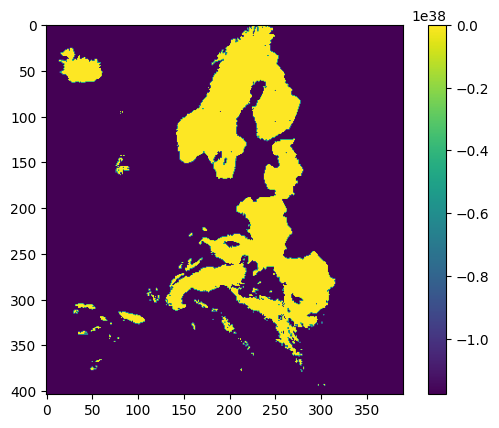

In [235]:
import osgeo.gdal as gdal
import matplotlib.pyplot as plt

# Read the ncdf4 file
dataset = gdal.Open(file)

# Get the data from the dataset
data = dataset.ReadAsArray()

# Plot the data
plt.imshow(data)
plt.colorbar()
plt.show()


In [ ]:
import os
import subprocess
import glob

# Specify the directory you want to search
directory = '/Users/khant/Documents/UFZ/BioDT/NC/'

# Get list of all .nc files in the directory
files = glob.glob(os.path.join(directory, '*.nc'))

# Loop over files
for file in files:
    # Define the output file name
    
    output_file = "/Users/khant/Documents/UFZ/BioDT/NC_python/"+ os.path.splitext(os.path.basename(file))[0] + '.nc'
    #print(output_file)
    # Run gdal_translate
    subprocess.run(['gdal_translate', '-of', 'netCDF', '-co', 'COMPRESS=DEFLATE', file, output_file])

# Works with `NC2` folder

In [89]:
import xarray as xr

sample = xr.open_dataset('/Users/khant/Documents/UFZ/BioDT/NC2/CHELSA_bio1_2011-2040_gfdl-esm4_ssp126_V.2.1.nc')
sample


<xarray.Dataset>
Dimensions:                       (x: 390, y: 404,
                                   lambert_azimuthal_equal_area: 1)
Coordinates:
  * x                             (x) float64 2.635e+06 2.645e+06 ... 6.525e+06
  * y                             (y) float64 5.415e+06 5.405e+06 ... 1.385e+06
  * lambert_azimuthal_equal_area  (lambert_azimuthal_equal_area) |S1 b'l'
Data variables:
    bio1                          (y, x) float32 ...

In [91]:
import xarray as xr
import os
import numpy as np
from natsort import natsorted

# Define the directory path where the netCDF files are located
directory = "/Users/khant/Documents/UFZ/BioDT/NC2/"

# Get a list of all netCDF files in the directory
files = natsorted([file for file in os.listdir(directory) if file.endswith(".nc")])


# Create an empty dictionary to store the datasets
datasets_m = {}
datasets_c = {}

# Iterate over each netCDF file
for file in files:
    # Open the netCDF file using xarray
    ds = xr.open_dataset(os.path.join(directory, file))
    variables = list(ds.data_vars)

    
    if "ClimModel" in ds[variables[0]].attrs and "ClimScenario" in ds[variables[0]].attrs and "TimePeriod" in ds[variables[0]].attrs:
        # Get the unique ClimModel and ClimScenario attributes
        clim_model = ds[variables[0]].attrs["ClimModel"]
        clim_scenario =  ds[variables[0]].attrs["ClimScenario"]
        time_period =  ds[variables[0]].attrs["TimePeriod"]
        #ds[variables[0]].attrs["lambert_azimuthal_equal_area"]
        #ds[variables[0]].attrs["LongName"] = ds[variables[0]].attrs["Long_name"]
        #ds[variables[0]].attrs.pop("Long_name", None)
        #ds[variables[0]].attrs["Var"] = ds.attrs["Var"]
        ds[variables[0]].attrs["Explanation"] = ds[variables[0]].attrs["explanation"]
        del ds[variables[0]].attrs["explanation"]
        ds.attrs['ClimModel'] = clim_model
        ds.attrs['ClimScenario'] = clim_scenario
        ds.attrs['TimePeriod'] = time_period
        #ds.attrs['crs_wkt'] = str(ds[variables[1]].attrs["crs_wkt"])
        #ds.attrs['spatial_ref'] = str(ds[variables[1]].attrs["spatial_ref"])
        #ds.attrs['proj4'] = str(ds[variables[1]].attrs["proj4"])
        #ds.attrs['epsg_code'] = str(ds[variables[1]].attrs["epsg_code"])
        #ds.attrs['geotransform'] = str(ds[variables[1]].attrs["geotransform"])
        #ds.attrs['crs'] = ds[variables[1]].attrs["crs_wkt"]
        #ds = ds.rename({variables[0]: ds.attrs["Var"]})
        
        # Create a key for the dataset dictionary using the ClimModel and ClimScenario attributes
        key = f"{clim_model}_{clim_scenario}_{time_period}"

        # Store the dataset in the dictionary
        if key not in datasets_m:
            datasets_m[key]=[]
        datasets_m[key].append(ds)
    # Get the unique ClimModel and ClimScenario attributes
    else:
        datasets_c["Current"] = ds


In [96]:
test = xr.merge(datasets_m["Current_Current_Current"])
test


<xarray.Dataset>
Dimensions:                       (x: 390, y: 404,
                                   lambert_azimuthal_equal_area: 1)
Coordinates:
  * x                             (x) float64 2.635e+06 2.645e+06 ... 6.525e+06
  * y                             (y) float64 5.415e+06 5.405e+06 ... 1.385e+06
  * lambert_azimuthal_equal_area  (lambert_azimuthal_equal_area) |S1 b'l'
Data variables: (12/46)
    bio1                          (y, x) float32 ...
    bio2                          (y, x) float32 ...
    bio3                          (y, x) float32 ...
    bio4                          (y, x) float32 ...
    bio5                          (y, x) float32 ...
    bio6                          (y, x) float32 ...
    ...                            ...
    ngd0                          (y, x) float32 ...
    ngd5                          (y, x) float32 ...
    ngd10                         (y, x) float32 ...
    npp                           (y, x) float32 ...
    scd                           (y, x) float32 ...
    swe                           (y, x) float32 ...
Attributes:
    ClimModel:     Current
    ClimScenario:  Current
    TimePeriod:    Current

In [99]:
import datetime
for key, ds in datasets_m.items():
# Combine all datasets into a single dataset
    merged_ds = xr.merge(ds)
    #merged_ds.attrs.pop("Var", None)
    #merged_ds.attrs.pop("Long_name", None)
    #merged_ds.attrs.pop("unit", None)
    #merged_ds.attrs.pop("explanation", None)
    del merged_ds.attrs["nchar"]
    merged_ds.attrs["Author"] = "Taimur Khan & Dr. Ahmed El-Gabbas, Helmholz Centre for Environmental Research (UFZ)"
    merged_ds.attrs["CreatedOn"] = str(datetime.datetime.now())
    merged_ds.attrs["EPSG"] = "3035"
    merged_ds.to_netcdf(f'/Users/khant/Documents/UFZ/BioDT/{key}.nc')

KeyError: 'nchar'

In [98]:
test = xr.open_dataset('/Users/khant/Documents/UFZ/BioDT/NC2_converted/Current_Current_Current.nc')
test

<xarray.Dataset>
Dimensions:                       (x: 390, y: 404,
                                   lambert_azimuthal_equal_area: 1)
Coordinates:
  * x                             (x) float64 2.635e+06 2.645e+06 ... 6.525e+06
  * y                             (y) float64 5.415e+06 5.405e+06 ... 1.385e+06
  * lambert_azimuthal_equal_area  (lambert_azimuthal_equal_area) |S1 b'l'
Data variables: (12/46)
    bio1                          (y, x) float32 ...
    bio2                          (y, x) float32 ...
    bio3                          (y, x) float32 ...
    bio4                          (y, x) float32 ...
    bio5                          (y, x) float32 ...
    bio6                          (y, x) float32 ...
    ...                            ...
    ngd0                          (y, x) float32 ...
    ngd5                          (y, x) float32 ...
    ngd10                         (y, x) float32 ...
    npp                           (y, x) float32 ...
    scd                           (y, x) float32 ...
    swe                           (y, x) float32 ...
Attributes:
    ClimModel:     Current
    ClimScenario:  Current
    TimePeriod:    Current
    Author:        Taimur Khan & Dr. Ahmed El-Gabbas, Helmholz Centre for Env...
    CreatedOn:     2024-03-15 11:10:45.662822
    EPSG:          3035

In [41]:
test = test.drop_vars(['lambert_azimuthal_equal_area', 'lambert_azimuthal_equal_area'])
test


<xarray.Dataset>
Dimensions:  (x: 390, y: 404)
Coordinates:
  * x        (x) float64 2.635e+06 2.645e+06 2.655e+06 ... 6.515e+06 6.525e+06
  * y        (y) float64 5.415e+06 5.405e+06 5.395e+06 ... 1.395e+06 1.385e+06
Data variables:
    bio1     (y, x) float32 ...

In [77]:
da = xr.open_dataset("http://134.94.199.14/ias-pdt/Test6.nc", engine="pydap", decode_times=False, chunks=None)
da

<xarray.Dataset>
Dimensions:                       (lambert_azimuthal_equal_area: 1, y: 404,
                                   x: 390)
Coordinates:
  * x                             (x) float64 2.635e+06 2.645e+06 ... 6.525e+06
  * y                             (y) float64 5.415e+06 5.405e+06 ... 1.385e+06
  * lambert_azimuthal_equal_area  (lambert_azimuthal_equal_area) int32 1
Data variables:
    Var                           (lambert_azimuthal_equal_area, y, x) float32 ...

TypeError: Invalid shape (1, 404, 390) for image data

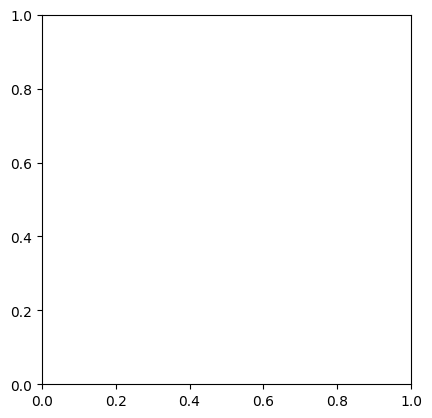

In [78]:
import matplotlib.pyplot as plt

plt.imshow(da['Var'])
plt.colorbar()
plt.show()
da.keys()

# tifs n `NC` folder

In [ ]:
import rioxarray as rxr

directory = "/Users/khant/Documents/UFZ/BioDT/NC"
    # Iterate over all files in the directory
for filename in os.listdir(directory):
        print("---------------------------------------------")
        output = filename.rsplit("_V")
        # Check if the file is a GeoTIFF
        if filename.endswith(".tif"):
            print(f"Reading {filename}...")

            # Open the GeoTIFF using rioxarray
            data = rxr.open_rasterio(os.path.join(directory, filename))
            print(f"Processing {filename} as xarray...")

            # Reproject the data to ESPG-3530
            data_europe = data.rio.reproject("EPSG:3035")
            print(f"Reprojecting {filename} as ESPG:3035...")


            # Convert to xarray DataArray to xrray Dataset
            dsout = data_europe.to_dataset(name=f"{output[0]}")

            print(f"Final dataset for {output[0]}: ")
            print(dsout)

            output_file_path = f"/Users/khant/Documents/UFZ/BioDT/t/{output[0]}.nc"

            # Convert the data to a netCDF4 file using xarray
            dsout.to_netcdf(output_file_path, mode="a", group="/", format="NETCDF4")
            print(
                f"{filename} processed and saved to {output_file_path} as {output[0]}"
            )

In [25]:
test = xr.open_dataset('http://localhost/CHELSA_bio14_1981-2010.nc', engine="pydap", decode_times=False, chunks=None)
test

<xarray.Dataset>
Dimensions:                 (band: 1, y: 404, x: 390)
Coordinates:
  * x                       (x) float64 2.635e+06 2.645e+06 ... 6.525e+06
  * y                       (y) float64 5.415e+06 5.405e+06 ... 1.385e+06
  * band                    (band) int32 1
Data variables:
    spatial_ref             int32 ...
    CHELSA_bio14_1981-2010  (band, y, x) float32 ...

In [138]:
import xarray as xr
import numpy as np

# Create longitude and latitude arrays
lon = np.linspace(-180, 180, 360)
lat = np.linspace(-90, 90, 180)

# Create dummy data arrays
data1 = np.random.rand(len(lat), len(lon))
data2 = np.random.rand(len(lat), len(lon))
data3 = np.random.rand(len(lat), len(lon))
data4 = np.random.rand(len(lat), len(lon))
data5 = np.random.rand(len(lat), len(lon))

# Create xarray dataset
ds = xr.Dataset(
    {
        'variable1': (['lat', 'lon'], data1),
        'variable2': (['lat', 'lon'], data2),
        'variable3': (['lat', 'lon'], data3),
        'variable4': (['lat', 'lon'], data4),
        'variable5': (['lat', 'lon'], data5),
    },
    coords={'lon': lon, 'lat': lat},
)

ds = ds.rio.write_crs("EPSG:3035", inplace=True).rio.set_spatial_dims(x_dim="lon",y_dim="lat",inplace=True).rio.write_coordinate_system(inplace=True)

# Add the "grid_mapping" attribute to each variable in the dataset
for var_name in ds.variables:
    ds[var_name].attrs['grid_mapping'] = 'spatial_ref'
    if var_name == "spatial_ref":
        ds[var_name].attrs['grid_mapping_name'] = "spatial_ref"

    
    #ds.transpose()

    # Rename "spatial_ref" variable to "lambert_azimuthal_equal_area" in ds
#ds = ds.rename({'spatial_ref': 'lambert_azimuthal_equal_area'})

# Print the dataset
print(ds)


<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360)
Coordinates:
  * lon          (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat          (lat) float64 -90.0 -88.99 -87.99 -86.98 ... 87.99 88.99 90.0
    spatial_ref  int64 0
Data variables:
    variable1    (lat, lon) float64 0.7634 0.1298 0.4431 ... 0.3313 0.1622


In [139]:
ds.to_netcdf('/Users/khant/Documents/UFZ/BioDT/dummy2.nc', format='NETCDF4', engine='netcdf4')

In [137]:
dummy = xr.open_dataset('/Users/khant/Documents/UFZ/BioDT/dummy.nc', decode_coords="all")
dummy

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360)
Coordinates:
  * lon          (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat          (lat) float64 -90.0 -88.99 -87.99 -86.98 ... 87.99 88.99 90.0
    spatial_ref  int64 ...
Data variables:
    variable1    (lat, lon) float64 ...
    variable2    (lat, lon) float64 ...
    variable3    (lat, lon) float64 ...
    variable4    (lat, lon) float64 ...
    variable5    (lat, lon) float64 ...

In [108]:
from osgeo import gdal
import subprocess

# Open the NetCDF file
ds = gdal.Open("/Users/khant/Documents/UFZ/BioDT/dummy.nc")

# Get the names of all subdatasets
subdatasets = ds.GetSubDatasets()

# Loop over all subdatasets
for i, subdataset in enumerate(subdatasets):
    # Get the name of the subdataset
    subdataset_name = subdataset[0]

    # Define the name of the output file
    output_file = f"/Users/khant/Documents/UFZ/BioDT/translated_dummy_{i}.nc"

    # Run gdal_translate on the subdataset
    subprocess.run(['gdal_translate', '-of', 'NetCDF', '-a_srs', 'EPSG:3035', subdataset_name, output_file])

/opt/homebrew/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Input file size is 360, 180
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 360, 180
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 360, 180
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 360, 180
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 360, 180
0...10...20...30...40...50...60...70...80...90...100 - done.


In [109]:
dap = xr.open_dataset("http://localhost/translated_dummy_0.nc", engine="pydap", decode_times=False, chunks=None)
dap

<xarray.Dataset>
Dimensions:                       (y: 180, x: 360)
Coordinates:
  * x                             (x) float64 -180.0 -179.0 ... 179.0 180.0
  * y                             (y) float64 -90.0 -88.99 -87.99 ... 88.99 90.0
Data variables:
    lambert_azimuthal_equal_area  |S128 ...
    variable1                     (y, x) float64 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.8.4, released 2024/02/08
    history:      Thu Mar 21 11:36:39 2024: GDAL CreateCopy( /Users/khant/Doc...

In [147]:

from osgeo import gdal
dods_dr = gdal.GetDriverByName('DODS')
if dods_dr is None:
    print('DODS driver is missing.')

# Open the NetCDF4 OpenDAP file
url = "http://localhost/dummy.nc"  # Replace this with your actual OpenDAP URL
dataset = gdal.Open(url)

# Check if the dataset is successfully opened
if dataset is None:
    print("Failed to open the dataset.")
else:
    print("Dataset successfully opened.")

DODS driver is missing.
Dataset successfully opened.


In [144]:
dataset.GetSubDatasets()

[('NETCDF:"/vsimem/http_1/dummy.nc":variable1',
  '[180x360] variable1 (64-bit floating-point)'),
 ('NETCDF:"/vsimem/http_1/dummy.nc":variable2',
  '[180x360] variable2 (64-bit floating-point)'),
 ('NETCDF:"/vsimem/http_1/dummy.nc":variable3',
  '[180x360] variable3 (64-bit floating-point)'),
 ('NETCDF:"/vsimem/http_1/dummy.nc":variable4',
  '[180x360] variable4 (64-bit floating-point)'),
 ('NETCDF:"/vsimem/http_1/dummy.nc":variable5',
  '[180x360] variable5 (64-bit floating-point)')]

In [146]:
subdatasets = dataset.GetSubDatasets()
for idx, subdataset in enumerate(subdatasets):
        print(f"Subdataset {idx+1}:")
        print(f"Name: {subdataset[0]}")
        print(f"Description: {subdataset[1]}")
        print(f"Attributes:")
        subdataset_ds = gdal.Open(subdataset[0])
        if subdataset_ds is not None:
            metadata = subdataset_ds.GetMetadata()
            for key, value in metadata.items():
                print(f"  {key}: {value}")
            subdataset_ds = None  # Close the subdataset dataset
        else:
            print("Failed to open subdataset.")
        print()

Subdataset 1:
Name: NETCDF:"/vsimem/http_1/dummy.nc":variable1
Description: [180x360] variable1 (64-bit floating-point)
Attributes:
Failed to open subdataset.

Subdataset 2:
Name: NETCDF:"/vsimem/http_1/dummy.nc":variable2
Description: [180x360] variable2 (64-bit floating-point)
Attributes:
Failed to open subdataset.

Subdataset 3:
Name: NETCDF:"/vsimem/http_1/dummy.nc":variable3
Description: [180x360] variable3 (64-bit floating-point)
Attributes:
Failed to open subdataset.

Subdataset 4:
Name: NETCDF:"/vsimem/http_1/dummy.nc":variable4
Description: [180x360] variable4 (64-bit floating-point)
Attributes:
Failed to open subdataset.

Subdataset 5:
Name: NETCDF:"/vsimem/http_1/dummy.nc":variable5
Description: [180x360] variable5 (64-bit floating-point)
Attributes:
Failed to open subdataset.



ERROR 4: NETCDF:"/vsimem/http_1/dummy.nc":variable1: No such file or directory
ERROR 4: NETCDF:"/vsimem/http_1/dummy.nc":variable2: No such file or directory
ERROR 4: NETCDF:"/vsimem/http_1/dummy.nc":variable3: No such file or directory
ERROR 4: NETCDF:"/vsimem/http_1/dummy.nc":variable4: No such file or directory
ERROR 4: NETCDF:"/vsimem/http_1/dummy.nc":variable5: No such file or directory


In [148]:
import netCDF4 as nc

# Path to your NetCDF file
file_path = url = "http://localhost/dummy.nc"

# Open the NetCDF file
nc_file = nc.Dataset(file_path, 'r')

print(nc_file.variables)

# Now you can work with the data in nc_file
# For example, you can access variables, dimensions, attributes, etc.

# Close the NetCDF file when you're done
nc_file.close()

{'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
unlimited dimensions: 
current shape = (180,)
filling off, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
unlimited dimensions: 
current shape = (360,)
filling off, 'variable1': <class 'netCDF4._netCDF4.Variable'>
float64 variable1(lat, lon)
unlimited dimensions: 
current shape = (180, 360)
filling off, 'variable2': <class 'netCDF4._netCDF4.Variable'>
float64 variable2(lat, lon)
unlimited dimensions: 
current shape = (180, 360)
filling off, 'variable3': <class 'netCDF4._netCDF4.Variable'>
float64 variable3(lat, lon)
unlimited dimensions: 
current shape = (180, 360)
filling off, 'variable4': <class 'netCDF4._netCDF4.Variable'>
float64 variable4(lat, lon)
unlimited dimensions: 
current shape = (180, 360)
filling off, 'variable5': <class 'netCDF4._netCDF4.Variable'>
float64 variable5(lat, lon)
unlimited dimensions: 
current shape = (180, 360)
filling off, 'spatial_ref': <class 'netCDF4._netCDF4.Variable'>
int32 spat

syntax error, unexpected WORD_WORD, expecting ';' or ','
context: Attributes { NC_GLOBAL { } variable1 { Float64 _FillValue nan; String coordinates "spatial_ref"; String grid_mapping "spatial_ref"; } variable2 { Float64 _FillValue nan; String coordinates "spatial_ref"; String grid_mapping "spatial_ref"; } variable3 { Float64 _FillValue nan; String coordinates "spatial_ref"; String grid_mapping "spatial_ref"; } variable4 { Float64 _FillValue nan; String coordinates "spatial_ref"; String grid_mapping "spatial_ref"; } variable5 { Float64 _FillValue nan; String coordinates "spatial_ref"; String grid_mapping "spatial_ref"; } spatial_ref { String crs_wkt "PROJCS["ETRS89-extended^ / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTIO